## Bibliotecas

In [159]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
from google.colab                import drive

In [160]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [161]:
df_segmentacao = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Segmentação de Clientes/online_retail_II.xlsx')
df_segmentacao.shape

(525461, 8)

In [162]:
df_segmentacao.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [163]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

## Tratamento de dados

In [164]:
#Retiramos dados nulos de consumidores
df_segmentacao = df_segmentacao[~df_segmentacao['Customer ID'].isna()].drop('Description', axis=1)

In [165]:
#Verificamos que existem quantidades negativas de compras
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 1]

In [166]:
#Retiramos dados de clientes que tiveram compra com valor nulo
df_segmentacao = df_segmentacao[df_segmentacao['Price'] != 0]

In [167]:
#Intervalo de tempo da base de dados
df_segmentacao['InvoiceDate'].agg(['min', 'max'])

#A data máxima será a medida final do intervalo de recencia
data_máxima = max(df_segmentacao['InvoiceDate'])

In [168]:
df_segmentacao['Customer ID'] = df_segmentacao['Customer ID'].astype(int).astype(str)
df_segmentacao.shape

(411981, 7)

In [169]:
#Quantidade de clientes únicos pertencentes a base de dados
len(df_segmentacao['Customer ID'].unique().tolist())

4362

In [170]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [171]:
#Criar análise de RFM para a base de clientes
df_segmentacao['Amount'] = df_segmentacao['Price'] * df_segmentacao['Quantity']

In [172]:
df_segmentacao.columns

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price',
       'Customer ID', 'Country', 'Amount'],
      dtype='object')

## [EDA]

In [173]:
df_segmentacao.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [174]:
#Indicadores
### Análise de cohort
### Ranking de lugares com maiores quantidades de venda


## RFM Analytcs

In [175]:
#Cria feature de montante transacionado
df_monetary = df_segmentacao.groupby('Customer ID')['Amount'].sum().reset_index()

#Cria feature de invoice consumida
df_frequency = df_segmentacao.groupby('Customer ID')['Invoice'].count().reset_index()


#Junta as features tratadas
rfm_dataframe = df_monetary.merge(df_frequency, on='Customer ID')

In [176]:
#Trazer feature de recência de cada consumidor
df_segmentacao['Recency'] = data_máxima - df_segmentacao['InvoiceDate']

#Buscamos a data mínima em dias de cada cliente
df_recency = df_segmentacao.groupby('Customer ID')['Recency'].min().reset_index()

#Tratamos a data
df_recency['Recency'] = df_recency['Recency'].dt.days

In [177]:
rfm_dataframe = rfm_dataframe.merge(df_recency, on='Customer ID')

In [178]:
#Quantidade de consumidores únicos
len(rfm_dataframe['Customer ID'].unique().tolist())

4362

In [179]:
# removing outliers
# outlier treatment for amount
Q1 = rfm_dataframe.Amount.quantile(0.05)
Q3 = rfm_dataframe.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Amount >= Q1 - 1.5*IQR) & (rfm_dataframe.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = rfm_dataframe.Recency.quantile(0.05)
Q3 = rfm_dataframe.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Recency >= Q1 - 1.5*IQR) & (rfm_dataframe.Recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = rfm_dataframe.Invoice.quantile(0.05)
Q3 = rfm_dataframe.Invoice.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Invoice >= Q1 - 1.5*IQR) & (rfm_dataframe.Invoice <= Q3 + 1.5*IQR)]

In [180]:
len(rfm_dataframe['Customer ID'].unique().tolist())

4277

## [Exp.1] RFM Score

In [181]:
rfm_dataframe["R_Score"] = pd.qcut(rfm_dataframe["Recency"],5,labels=[5,4,3,2,1])
rfm_dataframe["F_Score"] = pd.qcut(rfm_dataframe["Invoice"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm_dataframe["M_Score"] = pd.qcut(rfm_dataframe["Amount"],5,labels=[1,2,3,4,5])
rfm_dataframe["RFM_Score"] = rfm_dataframe["R_Score"].astype(str) + rfm_dataframe["F_Score"].astype(str) + rfm_dataframe["M_Score"].astype(str)

rfm_dataframe.head()

,Customer ID,Amount,Invoice,Recency,R_Score,F_Score,M_Score,RFM_Score
0,12346,27.02,44,66,3,3,1,331
1,12347,1323.32,71,2,5,4,4,544
2,12348,222.16,20,73,2,2,1,221
3,12349,2646.99,107,42,3,4,5,345
4,12351,300.93,21,10,5,2,2,522


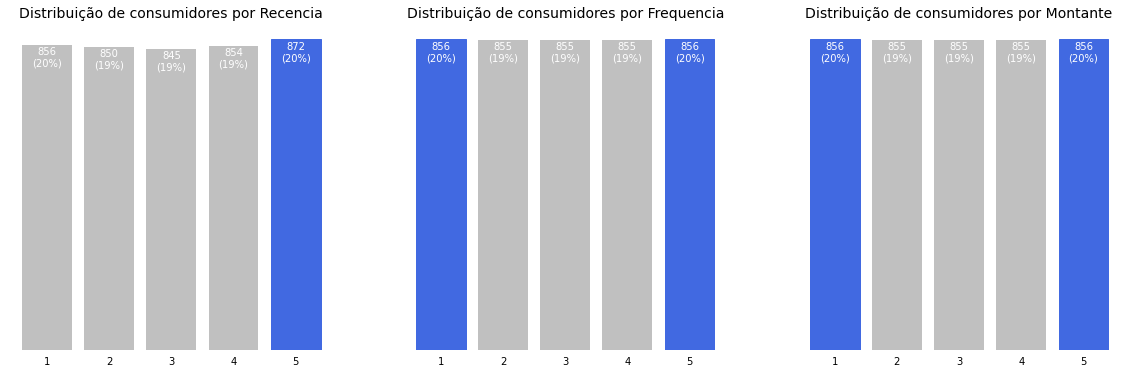

In [182]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

for i, p in enumerate(['R_Score', 'F_Score','M_Score']):
    parameters = {'R_Score':'Recencia', 'F_Score':'Frequencia', 'M_Score':'Montante'}
    y = rfm_dataframe[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribuição de consumidores por {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('royalblue')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

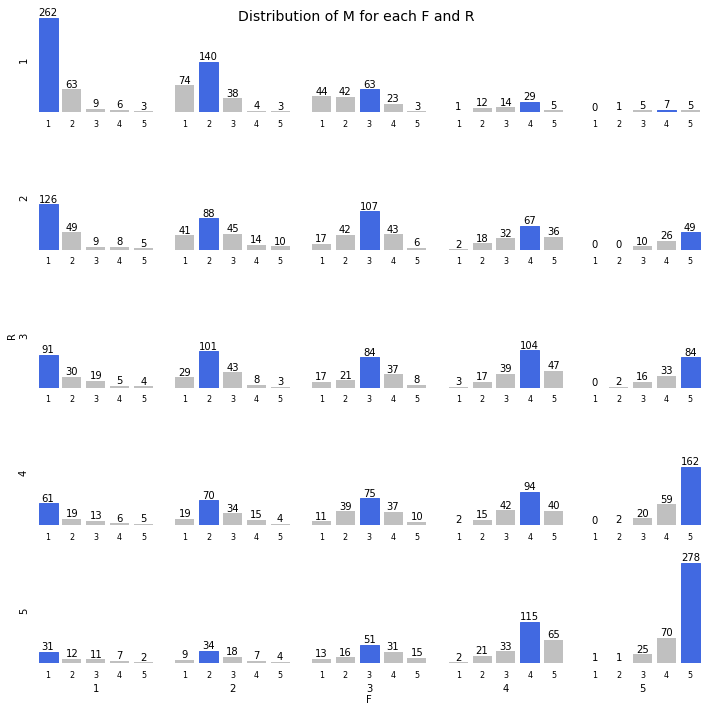

In [183]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm_dataframe[(rfm_dataframe['R_Score'] == r) & (rfm_dataframe['F_Score'] == f)]['M_Score'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('royalblue')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

## Clustering K-Means

In [184]:
#Base de dados que será utilizado para o modelo de K-Means
df_model = rfm_dataframe[['Customer ID','Amount', 'Invoice', 'Recency']]
df_model.head()

,Customer ID,Amount,Invoice,Recency
0,12346,27.02,44,66
1,12347,1323.32,71,2
2,12348,222.16,20,73
3,12349,2646.99,107,42
4,12351,300.93,21,10


### Normalização de dados

In [192]:
#Normalização de dados
escalonamento = MinMaxScaler((0,1))
rfm = escalonamento.fit_transform(df_model[['Recency','Amount','Invoice']])
rfm

### Treino 

In [194]:
k_means = KMeans(n_clusters = 10)
k_clusters = k_means.fit(rfm)

print(k_clusters.n_clusters)

In [198]:
cl = 20
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        random_state=42)

    model = model.fit(rfm)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

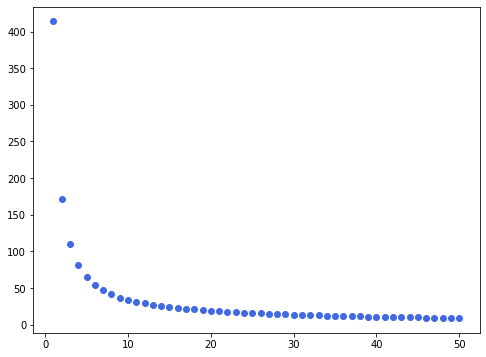

The best K sugest:  9


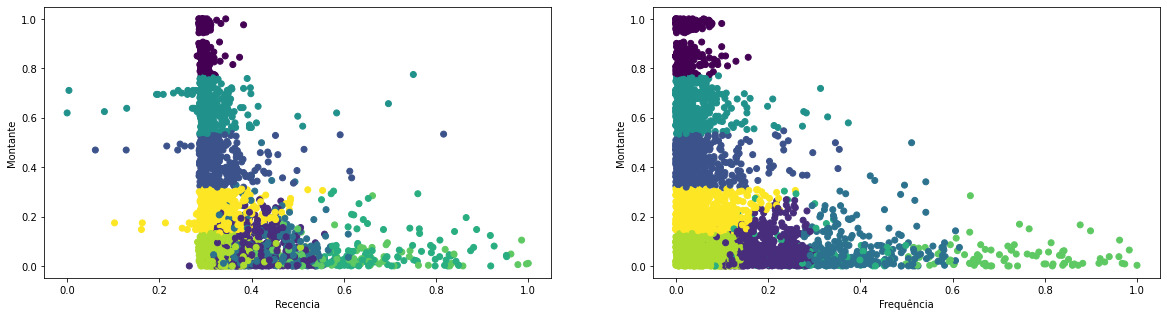

In [203]:
plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='royalblue')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(rfm)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)

plt.scatter(x = rfm[:,1], y = rfm[:,0], c=model.labels_.astype(float))
ax.set_xlabel('Recencia')
ax.set_ylabel('Montante')
ax = fig.add_subplot(122)
plt.scatter(x = rfm[:,2], y = rfm[:,0], c=model.labels_.astype(float))
ax.set_xlabel('Frequência')
ax.set_ylabel('Montante')

plt.show()